In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms as trns
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import import_ipynb
from dataset import create_datasets
from config import data_folder

importing Jupyter notebook from dataset.ipynb
importing Jupyter notebook from config.ipynb


In [2]:
def expand(img, background=(128, 128, 128), show=False):
    topil = trns.ToPILImage()
    totensor = trns.ToTensor()
    # 輸入的img是按NCHW刑事排列的Type(Tensor),需轉換型態
    img = np.array(topil(img)).astype(np.uint8)
    # 隨機生成貼上位置
    height, width, depth = img.shape
    ratio = random.uniform(1, 2)
    # 左邊界位置
    left = random.uniform(0.3 * width, width * ratio - width)
    # 右邊界位置
    top = random.uniform(0.3 * width, width * ratio - width)
    
    while int(left + width) > int(width * ratio) or int(top + height) > int(height * ratio):
        ratio = random.uniform(1, 2)
        left = random.uniform(0.3 * width, width * ratio - width)
        top = random.uniform(0.3 * width, width * ratio - width)
    
    # Create white background
    expand_img = np.zeros(
        (int(height * ratio), int(width * ratio),depth), dtype=img.dtype
    )

    # 將背景填充成灰色
    expand_img[:,:,:] = background
    expand_img[
        int(top) : int(top + height), int(left) : int(left + width)
    ] = img
    
    # display
    if show:
        expand_img_ = Image.fromarray(expand_img)
        draw = ImageDraw.ImageDraw(expand_img_)
        draw.rectangle(
            [(int(left), int(top)) , int(left + width), int(top + height)],
            outline=(0,255,0),
            width=2,
        )
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        plt.imshow(expand_img_)
        plt.show()
        
    # 紀錄圖片相對位置
    xmin = left / (width * ratio)
    ymin = top / (height * ratio)
    xmax = (left + width) / (width * ratio)
    ymax = (top + height) / (height * ratio)
    # 處理完之後還需要進行尺寸變換
    expand_img = totensor(
        Image.fromarray(expand_img).resize((32, 32), Image.BILINEAR)
    )
    return expand_img, torch.Tensor([xmin, ymin, xmax, ymax])

In [3]:
# 將生成方法直接寫入Dataset中
class BoxData(Dataset):
    def __init__(self, dataset, show=False):
        super(BoxData, self).__init__()
        self.dataset = dataset
        # 用於展示
        self.show = show
        
    def __getitem__(self, index):
        img, label = self.dataset[index]
        img, box = expand(img, show=self.show)
        return img, box
    def __len__(self):
        return len(self.dataset)

Files already downloaded and verified
Files already downloaded and verified


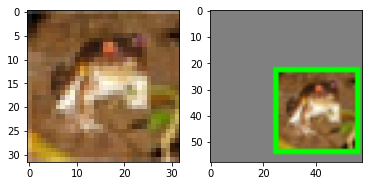

C:\Users\x9172\anaconda3\envs\PT\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


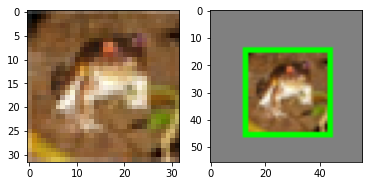

torch.Size([3, 32, 32]) torch.Size([4])


In [4]:
if __name__ == "__main__":
    trn = trns.Compose([trns.ToTensor()])
    train_loader, _ = create_datasets(data_folder, trn_train=trn)
    data = BoxData(train_loader.dataset, show=True)
    print(data[0][0].shape, data[0][1].shape)